<a href="https://colab.research.google.com/github/rvraghvender/Tech-Test-ML-Hand/blob/main/HandMasking_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand segmentation in Images (Background removal)


## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
- [3 - Data augmentation](#3)
- [4 - DeepLayerV3+ Architecture (Model)](#4)
    - [4.1 - Atrous Spatial Pyramid Pooling (ASPP)](#4.1)
- [5 - Defining the Metrics](#5)
- [6 - Creating data input pipelines](#6)
- [7 - Model fit](#7)
- [8 - Loading the saved model](#8)
- [9 - Prediction](#9)
- [10 - Conclusion](#10)
- [11 - References](#11)

Installing packages

In [ ]:
# %pip install gdown
# %pip install scikit-learn
# %pip install albumentations

## 1 - Packages

In [43]:
import zipfile
import gdown
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
from glob import glob
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# For Image augmentation
from albumentations import HorizontalFlip
from albumentations import VerticalFlip
from albumentations import GridDistortion
from albumentations import OpticalDistortion
from albumentations import ChannelShuffle
from albumentations import CoarseDropout
from albumentations import CenterCrop
from albumentations import Crop
from albumentations import Rotate


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras.utils import CustomObjectScope

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# %rm new_data -r
# %rm files -r

## 2 - Loading and splitting the dataset

The dataset `public_hand_dataset` is provided to us as a shared Google Drive format.

In [45]:
file_name = 'public_hand_dataset.zip'

if not os.path.isfile(file_name):
    file_id = '1Mc72BLGnZZQ0mhnh9rHOdJzYmITN-PPL'
    url = f'https://drive.google.com/uc?id={file_id}'

    downloaded_file = gdown.download(url, quiet=False)
    with zipfile.ZipFile(downloaded_file) as zf:
        zf.extractall()
else:
    print('File already exists.')

File already exists.


In [46]:
file_name_prefix = file_name.split('.')[0]
list_folder = os.listdir(file_name_prefix)
print(f'Number of examples provided in the dataset: {len(list_folder)}')

Number of examples provided in the dataset: 150


In [47]:
# Creating directories
def create_dir(path):
    ''' Create the directory if it does not exist in given path'''
    if not os.path.exists(path):
        os.makedirs(path)

In [48]:
def load_data(path, split=0.1):
    '''
    Split the data for training and testing.

    Arguments:
    path -- directory path(s) containing the masked and original images
    split -- fraction of value (between 0 & 1) to split the image data

    Returns:
    train_x -- split the data (list) into train data containing original images
    train_y -- split the data (list) into train data containing original mask images
    test_x -- split the data (list) into test data containing original images
    test_y -- split the data (list) into test data containing original mask images
    '''

    # Loading the original and mask images"
    X = sorted(glob(os.path.join(path, "*", "original", "*.jpeg")))
    Y = sorted(glob(os.path.join(path, "*", "no_bg", "*.jpeg")))

    # Splitting the data into training and testing
    split_size = int(len(X) * split)

    train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [49]:
# Seting the seed value to be consistent
np.random.seed(42)

# Load the dataset
data_path = "public_hand_dataset"
(train_x, train_y), (test_x, test_y) = load_data(data_path)
print(f"Number of examples in Train data: \t{len(train_x)} - {len(train_y)}")
print(f"Number of examples in Test data: \t{len(test_x)} - {len(test_y)}")


Number of examples in Train data: 	135 - 135
Number of examples in Test data: 	15 - 15


Looking up the data

Text(0.5, 1.0, 'Masked image')

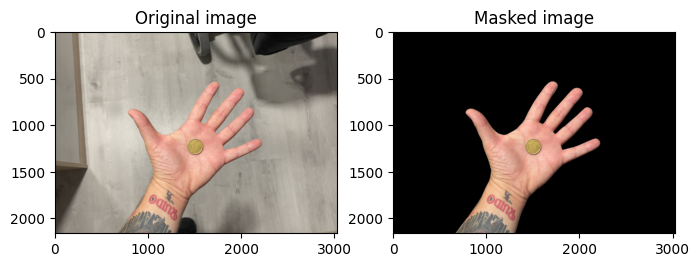

In [50]:
image_look_path = '5678812149462625182938872268415369219'

img = cv2.imread(os.path.join('public_hand_dataset', image_look_path, 'original', 'hand.jpeg'))[:,:,::-1]
mask = cv2.imread(os.path.join('public_hand_dataset', image_look_path, 'no_bg', 'hand.jpeg'))[:,:,::-1]

fig, arr = plt.subplots(1, 2, figsize=(8, 6))
arr[0].imshow(img)
arr[0].set_title('Original image')
arr[1].imshow(mask[:, :, :])
arr[1].set_title('Masked image')

## 3 - Data Augmentation

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. Data augmentation is especially useful when we have a small dataset. Furthermore, obtaining new data is often expensive, time taking and laborious. For example, if we have an image of a cat, we can rotate it, flip it, crop it, change its brightness, or add some noise to it. These transformations will produce new images that are different from the original one, but still contain the same information (a cat). By doing this, we can increase the size and diversity of your training set, which can help improve the performance and generalization of your model.  

In [51]:
# Creating directories to save the augumented data
create_dir("new_data/train/original_images/")
create_dir("new_data/train/mask_images/")
create_dir("new_data/test/original_images/")
create_dir("new_data/test/mask_images/")

In [52]:
# Data augmentation
def augment_data(images, masks, save_path, augment=True):

    # Fixing the size of image
    H = 256
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):

        # Extract the name of the image
        original_image_name = x.split('/')
        original_image_name = '-'.join(original_image_name[1:])

        mask_image_name = y.split('/')
        mask_image_name = '-'.join(mask_image_name[1:])

        # Reading the image and mask
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)


        # Augmentation
        if augment == True:

            # Flipping the image horizontally
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            # Grayscalling the image
            x2 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y2 = cv2.cvtColor(y, cv2.COLOR_RGB2GRAY)

            # Shuffling the RGB channel of the image
            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            # Mimicking the lost information from the data, thus artifically creating holes
            aug = CoarseDropout(p=1, min_holes=3, max_holes=10, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            # Rotating the image to 45 degrees
            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            # Collecting all the augmented images in list
            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]
        else:
            X = [x]
            Y = [y]

        index = 0  # Conter for incrementing different types of augmentation on the same image
        for i, m in zip(X, Y):

            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            image_path = os.path.join(save_path, "original_images", f"{index}_{original_image_name}")
            mask_path = os.path.join(save_path, "mask_images", f"{index}_{mask_image_name}")

            # Save image on disk
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [53]:
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x, test_y, "new_data/test/", augment=False) # For the test no augmentation will be used

100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Looking at various types of augmentation

Text(0.5, 1.0, 'Rotate')

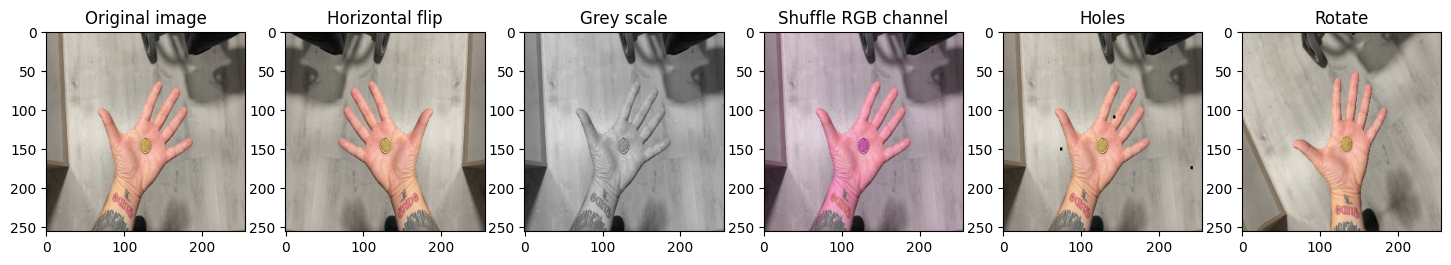

In [54]:
image_look_path = '5678812149462625182938872268415369219-original-hand.jpeg'

# opencv reads and displays an image as BGR format instead of RGB color format. Whereas matplotlib uses RGB color format to display image
# therefore [:,:,::-1] BGR to RGB
img = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'0_{image_look_path}'))[:,:,::-1]
aug1 = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'1_{image_look_path}'))[:,:,::-1]
aug2 = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'2_{image_look_path}'))[:,:,::-1]
aug3 = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'3_{image_look_path}'))[:,:,::-1]
aug4 = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'4_{image_look_path}'))[:,:,::-1]
aug5 = cv2.imread(os.path.join('new_data', 'train', 'original_images', f'5_{image_look_path}'))[:,:,::-1]


fig, arr = plt.subplots(1, 6, figsize=(18, 12))
arr[0].imshow(img)
arr[0].set_title('Original image')
arr[1].imshow(aug1[:, :, :])
arr[1].set_title('Horizontal flip')
arr[2].imshow(aug2[:, :, :])
arr[2].set_title('Grey scale')
arr[3].imshow(aug3[:, :, :])
arr[3].set_title('Shuffle RGB channel')
arr[4].imshow(aug4[:, :, :])
arr[4].set_title('Holes')
arr[5].imshow(aug5[:, :, :])
arr[5].set_title('Rotate')


For the rest of the part of this assignment, we will be working with the augmented data as a training data.

## 4 - U-Net Architecture


In [55]:
def conv_block(input, num_filters):
    " First layer convolution "
    conv_layer = Conv2D(num_filters, 3, padding='same')(input)
    conv_layer = BatchNormalization()(conv_layer)
    conv_layer = Activation('relu')(conv_layer)

    " Second layer convolution "
    conv_layer = Conv2D(num_filters, 3, padding='same')(conv_layer)
    conv_layer = BatchNormalization()(conv_layer)
    conv_layer = Activation('relu')(conv_layer)

    return conv_layer

In [56]:
def encoder_block(input, num_filters):
    conv_block_layer = conv_block(input, num_filters)     # For skip-connections memory
    conv_pool_layer = MaxPool2D((2,2))(conv_block_layer)  # After max-pooling

    return conv_block_layer, conv_pool_layer

In [57]:
def decoder_block(input, skip_features, num_filters):
    conv_block_layer = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    conv_block_layer = Concatenate()([conv_block_layer, skip_features])
    conv_block_layer = conv_block(conv_block_layer, num_filters)
    return conv_block_layer

In [58]:
def unet(input):

    " Input layer "
    input_layer = Input(input)

    " Encoder layer "
    encoder_layer_1, encoder_pool_1 = encoder_block(input_layer   , 64 )
    encoder_layer_2, encoder_pool_2 = encoder_block(encoder_pool_1, 128)
    encoder_layer_3, encoder_pool_3 = encoder_block(encoder_pool_2, 256)
    encoder_layer_4, encoder_pool_4 = encoder_block(encoder_pool_3, 512)

    " Bridge layer "
    bridge_layer = conv_block(encoder_pool_4, 1024)

    " Decoder  layer "
    decoder_layer_1 = decoder_block(bridge_layer,    encoder_layer_4, 512)
    decoder_layer_2 = decoder_block(decoder_layer_1, encoder_layer_3, 256)
    decoder_layer_3 = decoder_block(decoder_layer_2, encoder_layer_2, 128)
    decoder_layer_4 = decoder_block(decoder_layer_3, encoder_layer_1, 64 )

    " Output layer "
    output_layer = Conv2D(1, 1, padding='same', activation='sigmoid')(decoder_layer_4)

    " Model "
    model = Model(input_layer, output_layer, name='unet_model')

    return model

In [59]:
input_shape = (512, 512, 3)
unet_model = unet(input_shape)
unet_model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 512, 512, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_56 (Ba  (None, 512, 512, 64)         256       ['conv2d_59[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_56 (Activation)  (None, 512, 512, 64)         0         ['batch_normalization

Every channel in the convolution layer does not hold the same importance, therefore  `squeeze_and_excite` function is implemented which is channel-wise attention mechanism.
This analyses each channel and based on their importance it scales each channel.

In [60]:
# def squeeze_and_excite(inputs, ratio=8):
#     '''

#     '''
#     init = inputs
#     filters = init.shape[-1]   # number of filters
#     se_shape = (1, 1, filters) # shape of squeeze and excitation

#     se = GlobalAveragePooling2D()(init)  # To get the global embedding of each channel
#     se = Reshape(se_shape)(se)

#     # Squeezing the features and again aplying a dense layer with original filter size
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

#     x = init * se
#     return x

## 5 - Defining the Metrics

- iou - Intersection of Union
- dice_coef - Used to calculate the performance of the segmentation task
- dice_loss - This is used as loss function

In [61]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [62]:
def shuffling(x, y):
    ''' Takes the images (x) and mask (y) and shuffle them.'''
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [63]:
# Creating directory for saving the data of the model training.
create_dir("files")

## 6 - Creating data input pipelines

In [64]:
def read_image(path):
    ''' Reading and normalizing the original image data '''
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.
    x = x.astype(np.float32)
    return x

In [65]:
def read_mask(path):
    ''' Reading and normalizing the mask image data'''
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x / 255.
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [66]:
def tf_parse(x, y):
    '''
    Reads the path -> convert it into array -> convert to tensors

    Arguments:
    x -- path of original image
    y -- path of mask image
    '''
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    # cv2 is outside numpy function, therefore we need to include it in tensorflow environment
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [67]:
def tf_dataset(X, Y, batch=2):
    '''
    Takes the path of the images and convert it to compatible tensorflow dataset.
    For example, this function produces 10 batches with 2 examples in each batch.

    Arguments:
    X -- path of original image
    Y -- path of mask image
    batch -- Combines consecutive elements of this dataset into batches of default size 2

    Returns:
    dataset -- tensorflow dataset
    '''
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [68]:
# Global parameters
H = 256
W = 256
np.random.seed(42)
tf.random.set_seed(42)

# Modle Hyperparameters
batch_size = 12
lr = 1e-4
num_epochs = 100

# Defining the path of saving the model
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

dataset_path = 'new_data'
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'test')

train_x = sorted(glob(os.path.join(train_path, 'original_images', '*jpeg')))
train_y = sorted(glob(os.path.join(train_path, 'mask_images', '*jpeg' )))

# Shuffle the data for better generalization of the model
train_x, train_y = shuffling(train_x, train_y)

valid_x = sorted(glob(os.path.join(valid_path, 'original_images', '*jpeg' )))
valid_y = sorted(glob(os.path.join(valid_path,  'mask_images', '*jpeg' )))

print(f"Train dataset size: \t{len(train_x)} - {len(train_y)}")
print(f"Test dataset size: \t{len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# Model
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()


Train dataset size: 	810 - 810
Test dataset size: 	15 - 15
Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 256, 256, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_74 (Ba  (None, 256, 256, 64)         256       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_74 (Activation)  (

In [69]:
# Saving checkpoint
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),   # Save the weight files during training
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1), # if the loss does not decrease in 5 step then learning rate be decreased by factor 0.1.
    CSVLogger(csv_path), # to record all the metrics data while traning in csv format
    TensorBoard(), # to log all the activites in the tensorboard
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False), # if the model 'val_loss' does not decrease for last 20 steps, it will stop training the model
]

## 7 - Model fit

In [70]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.6025 - dice_coef: 0.3977 - iou: 0.2513 - recall_2: 0.7570 - precision_2: 0.5664
Epoch 1: val_loss improved from inf to 0.83428, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 98s 892ms/step - loss: 0.6025 - dice_coef: 0.3977 - iou: 0.2513 - recall_2: 0.7570 - precision_2: 0.5664 - val_loss: 0.8343 - val_dice_coef: 0.1555 - val_iou: 0.0844 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.5078 - dice_coef: 0.4922 - iou: 0.3275 - recall_2: 0.7501 - precision_2: 0.7926
Epoch 2: val_loss did not improve from 0.83428
68/68 [==============================] - 48s 699ms/step - loss: 0.5078 - dice_coef: 0.4922 - iou: 0.3275 - recall_2: 0.7501 - precision_2: 0.7926 - val_loss: 0.8674 - val_dice_coef: 0.1240 - val_iou: 0.0662 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.4712 - dice_coef: 0.5287 - iou: 0.3604 - recall_2: 0.7540 - precision_2: 0.8523
Epoch 3: val_loss did not improve from 0.83428
68/68 [==============================] - 4

Downlaoding the saved model as a zip file

In [79]:
!zip -r model_unet.zip files
from google.colab import files
files.download('model_unet.zip')

  adding: files/ (stored 0%)
  adding: files/model.h5 (deflated 8%)
  adding: files/data.csv (deflated 52%)
  adding: files/score.csv (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8 - Loading the saved model

In [71]:
 np.random.seed(42)
 tf.random.set_seed(42)

 # Directory for storing files
 create_dir('results')

 # Load the model
 with CustomObjectScope({'iou' : iou, 'dice_coef' : dice_coef, 'dice_loss' : dice_loss}):
    model = tf.keras.models.load_model('files/model.h5')
    model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 256, 256, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_74 (Ba  (None, 256, 256, 64)         256       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_74 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization

In [72]:
# Load the test dataset
dataset_path = 'new_data'
test_x = sorted(glob(os.path.join(dataset_path, 'test', 'original_images', '*jpeg')))
test_y = sorted(glob(os.path.join(dataset_path, 'test', 'mask_images', '*jpeg')))
print(f'Test: \t{len(test_x)} - {len(test_y)}')

Test: 	15 - 15


In [73]:
def save_results(image, mask, y_pred, save_image_path):
    ## i - m - yp - yp*i
    line = np.ones((H, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1) # (512, 256, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1) # (512, 256, 3)
    mask = mask * 255.

    y_pred = np.expand_dims(y_pred, axis=-1) # (512, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) # (512, 256, 3)
    # y_pred = y_pred * 255.

    masked_image = image * y_pred
    y_pred = y_pred * 255.

    cat_images = np.concatenate([image, line, mask, line, y_pred, line, masked_image], axis=1)
    cv2.imwrite(save_image_path, cat_images)


In [74]:
# Evaluation and Prediction
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):

    # Extract the name
    name = x.split('/')
    name = '-'.join(name[3:])

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    x = image/ 255.0
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    # mask = mask/255.0

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the prediction
    save_image_path = f'results/{name}'
    save_results(image, mask, y_pred, save_image_path)

    # Flatten the array
    mask = mask.flatten()
    y_pred = y_pred.flatten()

    mask = [1 if k>= 1 else k for k in mask]

    # Calculating the metrics values
    acc_value = accuracy_score(mask, y_pred)
    f1_value = f1_score(mask, y_pred, labels=[0,1], average='binary')
    jaccard_value = jaccard_score(mask, y_pred, labels=[0,1], average='binary')
    recall_value = recall_score(mask, y_pred, labels=[0,1], average='binary')
    precision_value = precision_score(mask, y_pred, labels=[0,1], average='binary')
    SCORE.append([name, acc_value, f1_value, jaccard_value, recall_value, precision_value])


# Metrics values
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f'\nAccuracy : \t {score[0]:0.5f}')
print(f'F1 : \t {score[1]:0.5f}')
print(f'Jaccard : \t {score[2]:0.5f}')
print(f'Recall : \t {score[3]:0.5f}')
print(f'Precision : \t {score[4]:0.5f}')

df = pd.DataFrame(SCORE, columns=['Image', 'Accuracy', 'F1', 'Jaccard', 'Recall', 'Precision'])
df.to_csv('files/score.csv')

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 1/15 [00:02<00:31,  2.26s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2/15 [00:02<00:15,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 3/15 [00:03<00:09,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 4/15 [00:03<00:06,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 5/15 [00:03<00:05,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 6/15 [00:04<00:04,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 7/15 [00:05<00:04,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 8/15 [00:05<00:04,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 9/15 [00:06<00:03,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 10/15 [00:06<00:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 11/15 [00:06<00:01,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|████████  | 12/15 [00:07<00:01,  2.28it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 13/15 [00:07<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 14/15 [00:07<00:00,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]

Accuracy : 	 0.91339
F1 : 	 0.76485
Jaccard : 	 0.66077
Recall : 	 0.70097
Precision : 	 0.86341


### Looking at the predictions from test set


Text(810, 50, 'mask_predicted_RGB')

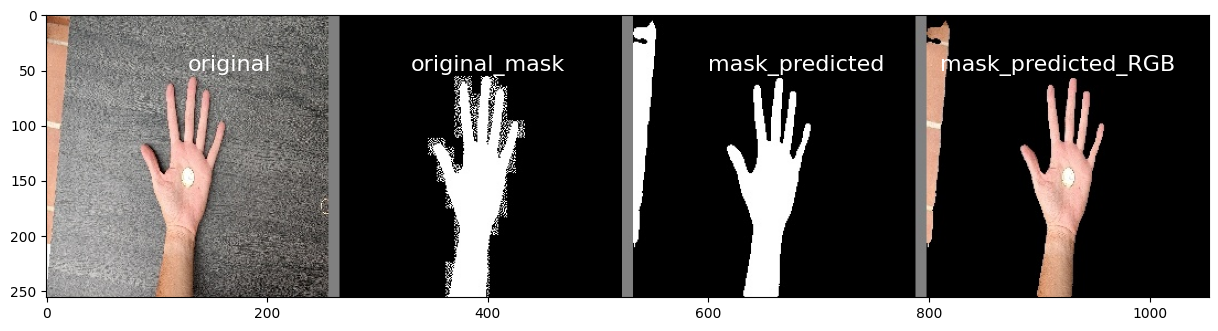

In [78]:
image_look_path = 'results/0_11981694530184251201902612474622181379-original-hand.jpeg'

img = cv2.imread(image_look_path)[:,:,::-1]
plt.figure(figsize=(15,6))
plt.imshow(img)
plt.text(128, 50, 'original', fontsize=16, color='w')
plt.text(330, 50, 'original_mask', fontsize=16, color='w')
plt.text(600, 50, 'mask_predicted', fontsize=16, color='w')
plt.text(810, 50, 'mask_predicted_RGB', fontsize=16, color='w')


Downloading the

## 9 - Prediction

I have downloaded few images from the internet and saved it in the folder named `test_hand`. Further, in the folder, a new sub folder is created with the name mask. Subsequently, for all the downloaded images, their masked images is predicted and saved in the sub mask folder.

In [ ]:
!unzip test_hand.zip

Archive:  test_hand.zip
  inflating: test_hand/Free Close-Up Photography of Girl's Left Hand Wearing Bracelet Stock Photo.jpg  
  inflating: test_hand/Free Close-Up Photography of Hand Stock Photo.jpg  
  inflating: test_hand/Free Couple  of hands Stock Photo (1).jpg  
  inflating: test_hand/Free Couple  of hands Stock Photo.jpg  
  inflating: test_hand/Free Crop model touching wrist of black woman Stock Photo.jpg  
  inflating: test_hand/Free Green and Gray Mountains Near Body of Water Stock Photo.jpg  
  inflating: test_hand/Free Hand Sign Stock Photo.jpg  
  inflating: test_hand/Free Left Hand Stock Photo.jpg  
  inflating: test_hand/Free Orange-petaled Flower Stock Photo.jpg  
  inflating: test_hand/Free Person Holding Light Bulb Stock Photo.jpg  
  inflating: test_hand/Free Person Holding White Rose Stock Photo.jpg  
  inflating: test_hand/Free Person Showing Right Hand Stock Photo.jpg  
  inflating: test_hand/Free Person's Hand on Water Stock Photo.jpg  
  inflating: test_hand/Fr

In [ ]:
data_x = glob('test_hand/*')

In [ ]:
create_dir('test_hand/mask')

In [ ]:
for path in tqdm(data_x, total=len(data_x)):
    name = path.split('/')[-1]

    # Reading the image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape

    x = cv2.resize(image, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Prediction
    y = model.predict(x)[0]
    y = cv2.resize(y, (w, h))
    y = np.expand_dims(y, axis=-1)

    # Save the images
    masked_image = image * y
    line = np.ones((h, 10, 3)) * 128
    cat_images = np.concatenate([image, line, masked_image], axis=1)
    cv2.imwrite(f'test_hand/mask/{name}', cat_images)

  0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 1/17 [00:00<00:02,  5.85it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 2/17 [00:00<00:02,  6.49it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 3/17 [00:00<00:02,  6.58it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▎       | 4/17 [00:00<00:01,  6.79it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██▉       | 5/17 [00:00<00:01,  6.57it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 6/17 [00:00<00:01,  6.69it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 7/17 [00:01<00:01,  7.02it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 8/17 [00:01<00:01,  7.38it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 9/17 [00:01<00:01,  7.37it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 10/17 [00:01<00:00,  7.17it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 11/17 [00:01<00:00,  7.20it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 12/17 [00:01<00:00,  7.34it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▋  | 13/17 [00:01<00:00,  7.11it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 14/17 [00:01<00:00,  7.34it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 15/17 [00:02<00:00,  7.39it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 16/17 [00:02<00:00,  7.21it/s]

1/1 [==============================] - 0s 56ms/step


100%|██████████| 17/17 [00:02<00:00,  7.04it/s]


Assessing our model's performance on randomly sourced internet images that include hands.

Text(580, 50, 'mask_predicted_RGB')

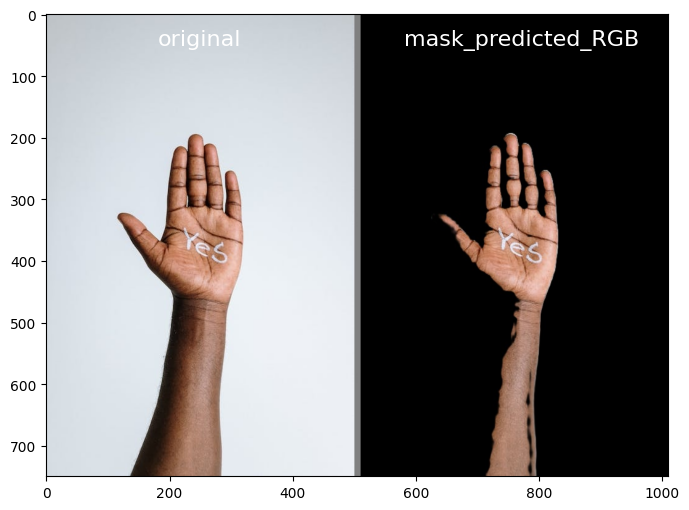

In [ ]:
image_look_path = "test_hand/mask/Free Photo Of Person's Hands Stock Photo.jpg"

img = cv2.imread(image_look_path)[:,:,::-1]
plt.figure(figsize=(15,6))
plt.imshow(img)
plt.text(180, 50, 'original', fontsize=16, color='w')
plt.text(580, 50, 'mask_predicted_RGB', fontsize=16, color='w')

## 10 - Conclusion

We've observed that our model effectively captures hands in images. Nevertheless, there's room for improvement in its accuracy. To enhance its performance, we can expand our training dataset to include more complex backgrounds and a wider range of hand poses. Additionally, diversifying the training data to include hands with various skin tones will be essential.

Furthermore, we can leverage other widely-used machine learning techniques to enhance the model's accuracy.

## 11 - Refrences
- https://developers.arcgis.com/python/guide/how-deeplabv3-works/